In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path


path = "/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/aligned/TiltSeries/EMPIAR_11969_aligned.mrcs"

with mrcfile.open(path, permissive=True) as mrc:
    data = mrc.data.copy()


In [2]:

print("shape:", data.shape)
print("dtype:", data.dtype)
print("min / max:", data.min(), data.max())


shape: (41, 5760, 4092)
dtype: float32
min / max: -0.55771637 256.21075


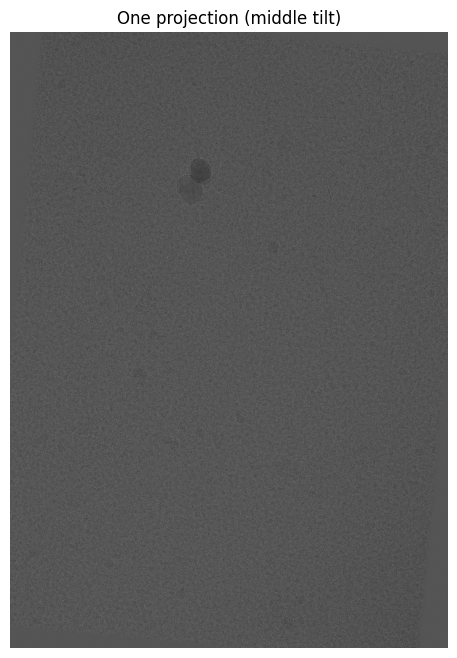

In [3]:
plt.figure(figsize=(12,8))
plt.imshow(data[data.shape[0]//2], cmap="gray")
plt.title("One projection (middle tilt)")
plt.axis("off")
plt.show()


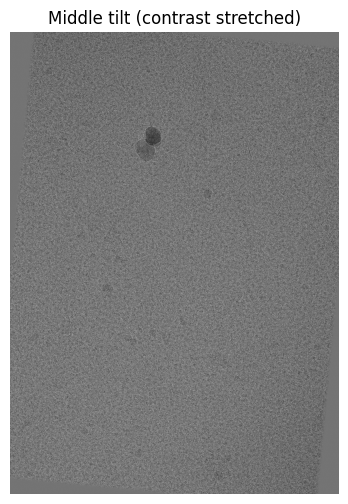

In [4]:
img = data[data.shape[0]//2]  # middle tilt projection

# robust contrast limits
lo, hi = np.percentile(img, (2, 98))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray", vmin=lo, vmax=hi)
plt.title("Middle tilt (contrast stretched)")
plt.axis("off")
plt.show()


In [5]:
import json
from pathlib import Path

meta_path = Path("/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/metadata/EMPIAR-11969_api.json")

meta = json.loads(meta_path.read_text(encoding="utf-8"))
print(type(meta))
print(list(meta.keys())[:20])


<class 'dict'>
['EMPIAR-11969']


In [6]:
print("RUNNING CELL")

import json
from pathlib import Path

meta_path = Path("/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/metadata/EMPIAR-11969_api.json")

text = meta_path.read_text(encoding="utf-8")
print("First 200 chars:")
print(text[:200])

meta = json.loads(text)
print("Loaded JSON type:", type(meta))
print("Top-level keys:", list(meta.keys())[:20])


RUNNING CELL
First 200 chars:
{"EMPIAR-11969":{"imagesets":[{"segmentations":[],"name":"Unaligned multiframe tilt images of mitotic chromosomes","directory":"data/Frames","category":"micrographs - multiframe","header_format":"TIFF
Loaded JSON type: <class 'dict'>
Top-level keys: ['EMPIAR-11969']


In [7]:
entry = meta["EMPIAR-11969"]

print("Entry keys:", list(entry.keys()))

imagesets = entry.get("imagesets", [])
print("Number of imagesets:", len(imagesets))

for i, s in enumerate(imagesets[:10]):
    print("\n--- imageset", i, "---")
    print("name:", s.get("name"))
    print("category:", s.get("category"))
    print("directory:", s.get("directory"))
    print("keys:", list(s.keys()))



Entry keys: ['imagesets', 'workflow_file', 'grant_references', 'version_history', 'title', 'principal_investigator', 'status', 'deposition_date', 'release_date', 'obsolete_date', 'update_date', 'corresponding_author', 'authors', 'cross_references', 'biostudies_references', 'idr_references', 'empiar_references', 'citation', 'dataset_size', 'experiment_type', 'scale', 'entry_doi']
Number of imagesets: 3

--- imageset 0 ---
name: Unaligned multiframe tilt images of mitotic chromosomes
category: micrographs - multiframe
directory: data/Frames
keys: ['segmentations', 'name', 'directory', 'category', 'header_format', 'data_format', 'num_images_or_tilt_series', 'frames_per_image', 'frame_range_min', 'frame_range_max', 'voxel_type', 'pixel_width', 'pixel_height', 'micrographs_file_pattern', 'picked_particles_file_pattern', 'picked_particles_directory', 'details', 'image_width', 'image_height']

--- imageset 1 ---
name: Aligned tilt series of mitotic chromosome
category: tilt series
directory: 

In [13]:
import mrcfile
import numpy as np

mrc_path = "/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/aligned/TiltSeries/EMPIAR_11969_aligned.mrcs"
with mrcfile.open(mrc_path, permissive=True) as mrc:
    stack = mrc.data  # shape (41, 5760, 4092)

n_tilts, Ny, Nx = stack.shape
y0 = Ny // 2
sino = stack[:, y0, :].astype(np.float32)  # (41, Nx)

print("stack:", stack.shape, "sinogram:", sino.shape)


stack: (41, 5760, 4092) sinogram: (41, 4092)


/home/ahopkins/KTH_TTMAM/MEX/odl_xray/venv/lib/python3.10/site-packages/odl/util/utility.py:1398: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_requirements


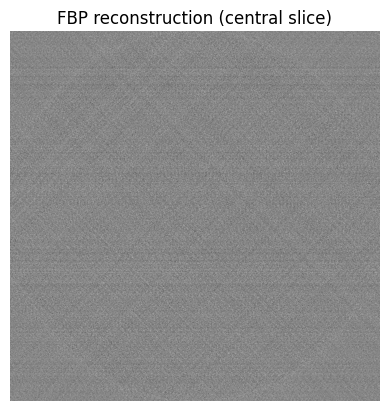

: 

In [ ]:
import odl

angles_deg = np.linspace(-60, 60, 41)
angles = np.deg2rad(angles_deg)

n_det = sino.shape[1]
px = 2.075  # Å

det_space = odl.uniform_partition(-(n_det/2)*px, (n_det/2)*px, n_det)
ang_space = odl.nonuniform_partition(angles)

geometry = odl.tomo.Parallel2dGeometry(ang_space, det_space)

N = 1024
fov = (n_det/2) * px
reco_space = odl.uniform_discr([-fov, -fov], [fov, fov], [N, N], dtype="float32")

ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
data = ray_trafo.range.element(sino.astype("float32"))

fbp = odl.tomo.fbp_op(ray_trafo)
reco = fbp(data)

# visualize 
plt.figure() 
plt.imshow(reco, cmap="gray") 
plt.title("FBP reconstruction (central slice)")
plt.axis("off") 
plt.show()
